In [1]:
#Workbench imports
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from pathlib import Path

### Load results from EMA Workbench run (see notebook 30), inspect and clean the raw results

In [2]:
from ema_workbench import load_results

target = Path("temp","experiments")
experiments, outcomes = load_results(target / "2021_2_23_EMA_experiments_five_hundred.tar.gz")
experiments.tail()

C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\Ginkel\AppData\Local\Continuum\anaconda3\envs\urban-SETP\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


,Housing_market,SLR,implementation_time,transient,Mayor,scenario,policy,model
395995,rational,1,4,SurgeHeight\five_hundred\five_hundred_430.csv,Lawkeeper,98995,3,Rotty
395996,rational,3,13,SurgeHeight\five_hundred\five_hundred_453.csv,Lawkeeper,98996,3,Rotty
395997,boundedly_rational,3,10,SurgeHeight\five_hundred\five_hundred_157.csv,Lawkeeper,98997,3,Rotty
395998,boundedly_rational,5,11,SurgeHeight\five_hundred\five_hundred_32.csv,Lawkeeper,98998,3,Rotty
395999,rational,6,4,SurgeHeight\five_hundred\five_hundred_308.csv,Lawkeeper,98999,3,Rotty


In [3]:
experiments2 = experiments.drop(['policy','model'],axis=1)
experiments2.head()

,Housing_market,SLR,implementation_time,transient,Mayor,scenario
0,boundedly_rational,4,12,SurgeHeight\five_hundred\five_hundred_119.csv,R. Active,0
1,boundedly_rational,4,14,SurgeHeight\five_hundred\five_hundred_90.csv,R. Active,1
2,boundedly_rational,2,10,SurgeHeight\five_hundred\five_hundred_220.csv,R. Active,2
3,boundedly_rational,9,9,SurgeHeight\five_hundred\five_hundred_141.csv,R. Active,3
4,rational,5,13,SurgeHeight\five_hundred\five_hundred_7.csv,R. Active,4


In [4]:
experiments3 = experiments2.copy()

map_house_market = {'rational' : '1', 
             'boundedly_rational' :'0'}

map_house_market_invert = {'1':'R', 
                           '0':'BR'}

map_mayor = {'H. Economicus': '2',
             'Sentiment' : '1',
             'R. Active' : '0',
             'Lawkeeper' : '3'}

map_mayor_invert = { '2' : 'Economic',
                    '1' : 'Sentiment',
                    '0' : 'Reactive',
                    '3' : 'Proactive'
                    }


rename_cols = {'Housing_market' : 'Housing market (R1)',
               'SLR' : 'SLR scenario (X1)',
               'implementation_time' : 'Implementation time (X3)',
               'transient' : 'Transient storm surge (X2)',
               'Mayor' : 'Management strategy (L1)'}

experiments3['Housing_market'].replace(map_house_market,inplace=True)
experiments3['Mayor'].replace(map_mayor,inplace=True)
experiments3['transient'] = experiments3['transient'].apply(lambda s : int(s.split('_')[-1].split('.')[0]))
cols_convert = ['transient', 'implementation_time']
experiments3[cols_convert] = experiments3[cols_convert].astype('int')
experiments3 = experiments3.rename(columns=rename_cols)
experiments3.head()

,Housing market (R1),SLR scenario (X1),Implementation time (X3),Transient storm surge (X2),Management strategy (L1),scenario
0,0,4,12,119,0,0
1,0,4,14,90,0,1
2,0,2,10,220,0,2
3,0,9,9,141,0,3
4,1,5,13,7,0,4


In [5]:
experiments3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396000 entries, 0 to 395999
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Housing market (R1)         396000 non-null  object  
 1   SLR scenario (X1)           396000 non-null  category
 2   Implementation time (X3)    396000 non-null  int32   
 3   Transient storm surge (X2)  396000 non-null  int32   
 4   Management strategy (L1)    396000 non-null  object  
 5   scenario                    396000 non-null  category
dtypes: category(2), int32(2), object(2)
memory usage: 14.2+ MB


# Scenario discovery
Scenario discovery seeks to find (orthogonal) subspaces with high density of points of interest. Here, we search for the the uncertainties (X1-X3) and policies (L1) with a high density of tipping points before 2200.

The optimisations towards high density of tipping points has a trade-off: the coverage, i.e. the number of tipping points inside the box (as fraction of total number of tipping points) goes down.

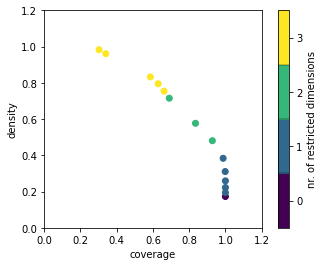

In [143]:
%matplotlib inline

from ema_workbench.analysis import prim
x = experiments3
y = outcomes['CC_first_SETP'] < 2200
prim_alg = prim.Prim(x,y,threshold=0.9)
box1 = prim_alg.find_box()
fig = box1.show_tradeoff()

SLR scenario (X1) [1, 2, 3, 4, 5, 6, 7, 8, 9]
Management strategy (L1) ['0', '1', '2', '3']


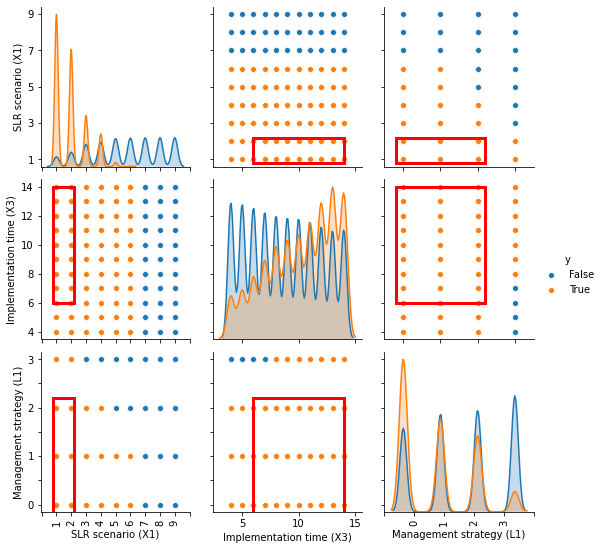

In [20]:
box1.show_pairs_scatter(i=10)

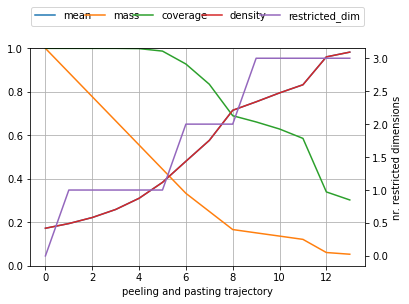

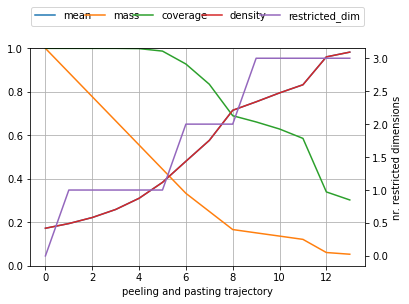

In [18]:
box1.show_ppt()

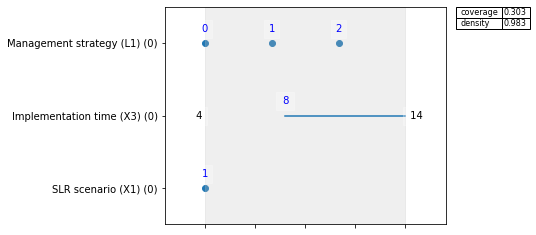

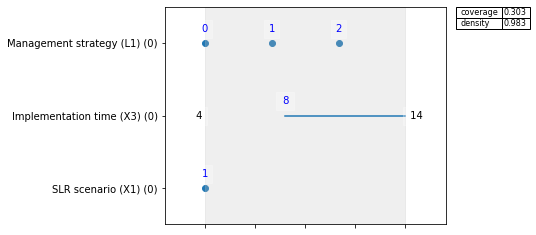

In [171]:
box1.inspect(13,style='graph')

## Make more insightfull graphs

In [70]:
colors = ['#61217B','#0057A5','#008ABE','#008D36','#7DAF23','#DABB00','#E29000','#CA280E','#942A36']
color_dict = {0:'#0057A5',
              1: '#CA280E',
              2: '#008D36',
              3: '#61217B'}

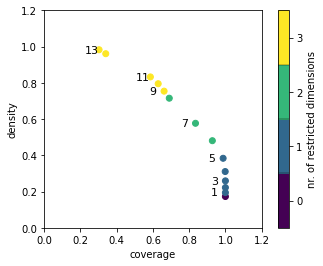

In [159]:
df = box1.peeling_trajectory
df['color'] = df.res_dim.apply(lambda x: color_dict[x])
df['step'] = df.index

def label_point(x, y, val, ax,offset=0,size=10,only_uneven = False):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if (only_uneven and i%2 != 1):
            pass
        else:
            ax.text(point['x']+offset, point['y'], str(int(point['val'])),size=size,verticalalignment='center')

fig, ax = plot_tradeoff(df)
label_point(df['coverage'],df['density'],df['step'],offset=-0.08,size=11,ax=ax,only_uneven=True)

In [168]:
box1.__dict__

{'prim': <ema_workbench.analysis.prim.Prim at 0x1e8a0075f70>,
 'peeling_trajectory':     coverage   density  id      mass      mean res_dim    color  step
 0   1.000000  0.172687   0  1.000000  0.172687       0  #0057A5     0
 1   1.000000  0.194273   1  0.888889  0.194273       1  #CA280E     1
 2   1.000000  0.222026   2  0.777778  0.222026       1  #CA280E     2
 3   1.000000  0.259030   3  0.666667  0.259030       1  #CA280E     3
 4   0.998874  0.310486   4  0.555556  0.310486       1  #CA280E     4
 5   0.987409  0.383653   5  0.444444  0.383653       1  #CA280E     5
 6   0.927966  0.480742   6  0.333333  0.480742       2  #008D36     6
 7   0.834991  0.576768   7  0.250000  0.576768       2  #008D36     7
 8   0.690264  0.715197   8  0.166667  0.715197       2  #008D36     8
 9   0.661631  0.754159   9  0.151500  0.754159       3  #61217B     9
 10  0.629051  0.795153  10  0.136614  0.795153       3  #61217B    10
 11  0.585956  0.832658  11  0.121523  0.832658       3  #61217B

In [161]:
from datetime import datetime
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
target = Path('Visualisations') / date

if not Path.exists(target): Path.mkdir(target)

fig.savefig((target / "SD_PRIM_tradeoff_EMA_2021_2_23.png"),bbox_inches="tight",dpi=200)

In [160]:
#Slightly adapted from EMA-workbench

import matplotlib as mpl
import numpy as np

def plot_tradeoff(peeling_trajectory, cmap=mpl.cm.viridis):  # @UndefinedVariable
    '''Visualize the trade off between coverage and density. Color
    is used to denote the number of restricted dimensions.
    Parameters
    ----------
    cmap : valid matplotlib colormap
    Returns
    -------
    a Figure instance
    '''

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    boundaries = np.arange(-0.5,
                           max(peeling_trajectory['res_dim']) + 1.5,
                           step=1)
    ncolors = cmap.N
    norm = mpl.colors.BoundaryNorm(boundaries, ncolors)

    p = ax.scatter(peeling_trajectory['coverage'],
                   peeling_trajectory['density'],
                   c=peeling_trajectory['res_dim'],
                   norm=norm,
                   cmap=cmap)
    ax.set_ylabel('density')
    ax.set_xlabel('coverage')
    ax.set_ylim(bottom=0, top=1.2)
    ax.set_xlim(left=0, right=1.2)

    ticklocs = np.arange(0,
                         max(peeling_trajectory['res_dim']) + 1,
                         step=1)
    cb = fig.colorbar(p, spacing='uniform', ticks=ticklocs,
                      drawedges=True)
    cb.set_label("nr. of restricted dimensions")

    return fig, ax